1. Loading embeddings...
RNA embeddings shape: (12494, 64)
Protein embeddings shape: (30005, 64)

2. Computing spot-level predictions...
Similarity matrix shape: torch.Size([30005, 12494])
Top-k scores shape: torch.Size([30005, 50]), Top-k indices shape: torch.Size([30005, 50])
Weights shape: torch.Size([30005, 50])
Predicted proteins shape: (12494, 2484)
Predicted proteins at spots shape: torch.Size([30005, 2484])

3. Loading ground truth data...


/home/yoyowu/miniconda3/envs/performer/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)



4. Preparing validation data...
Number of overlapping proteins: 49


/tmp/ipykernel_3152760/2061750282.py:475: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(cell_types))
/tmp/ipykernel_3152760/2061750282.py:475: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab10', len(cell_types))
/tmp/ipykernel_3152760/2061750282.py:317: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("viridis")
/tmp/ipykernel_3152760/2061750282.py:317: MatplotlibDeprecationWarning: The get_cmap func

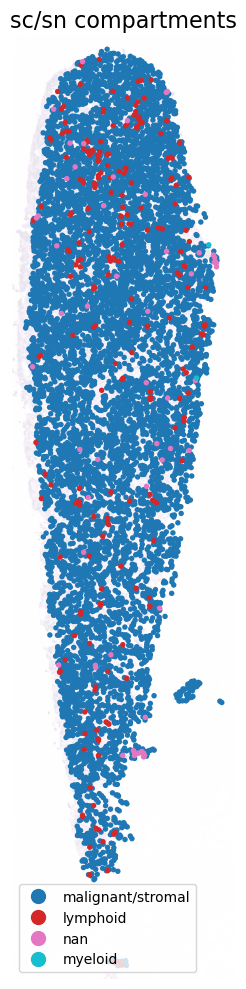

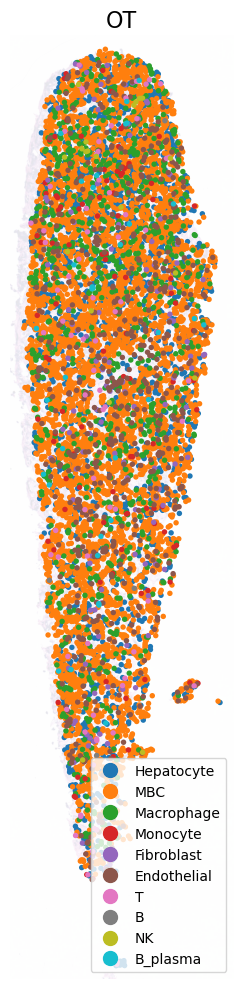

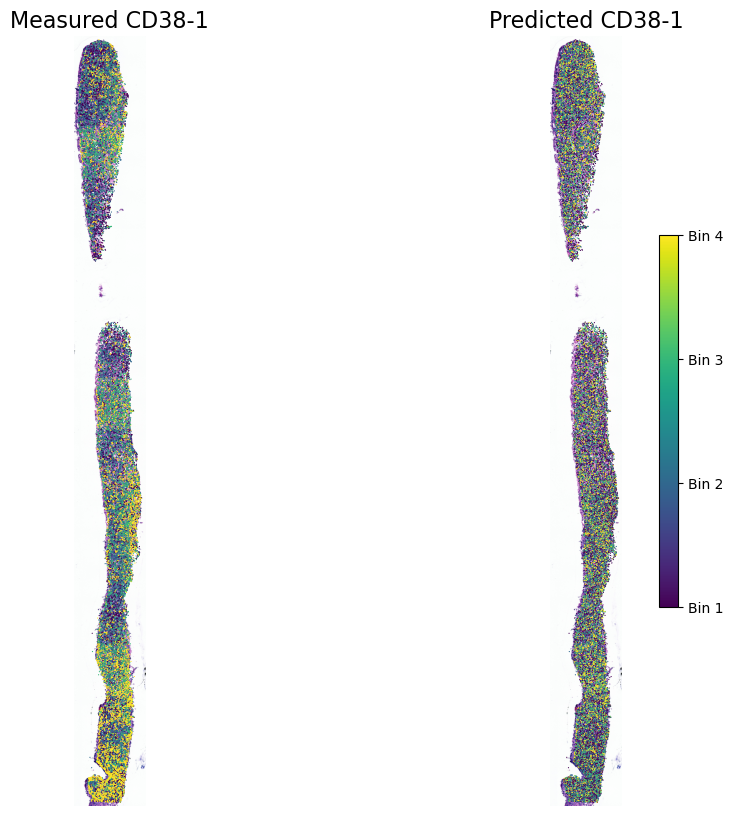

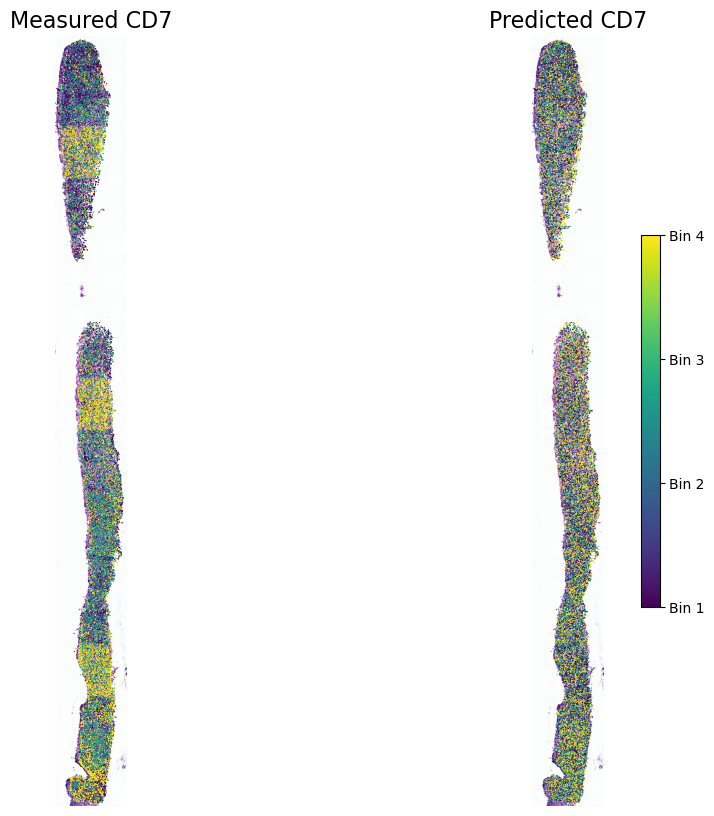

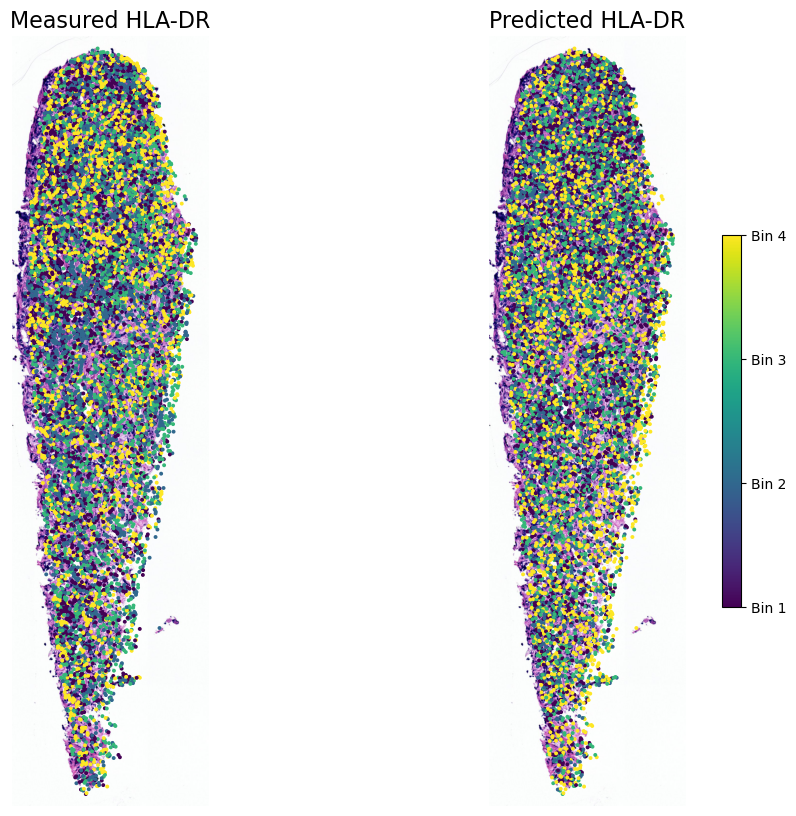

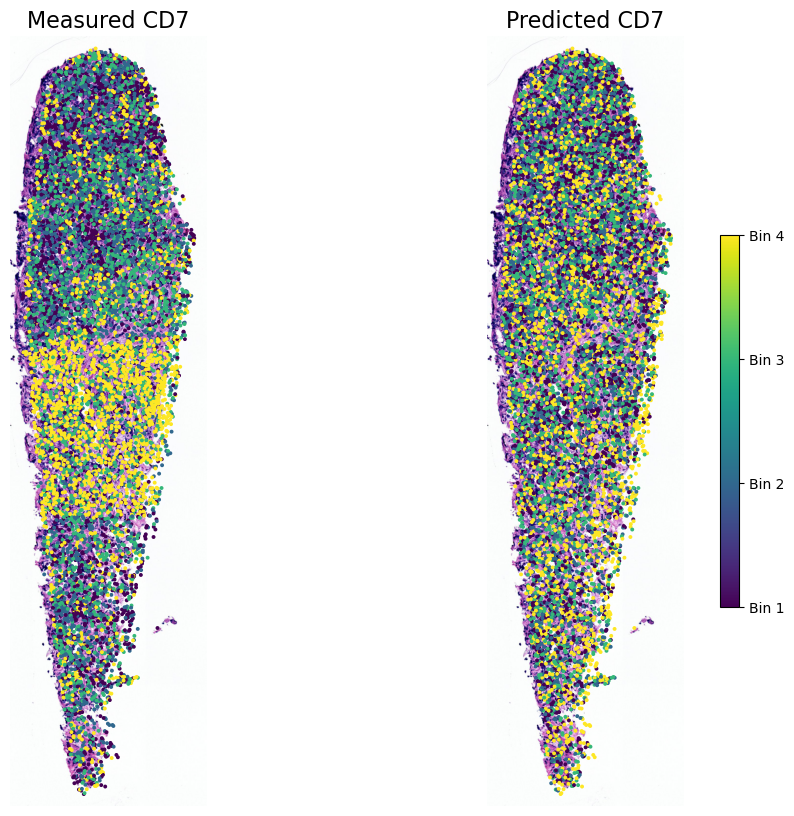

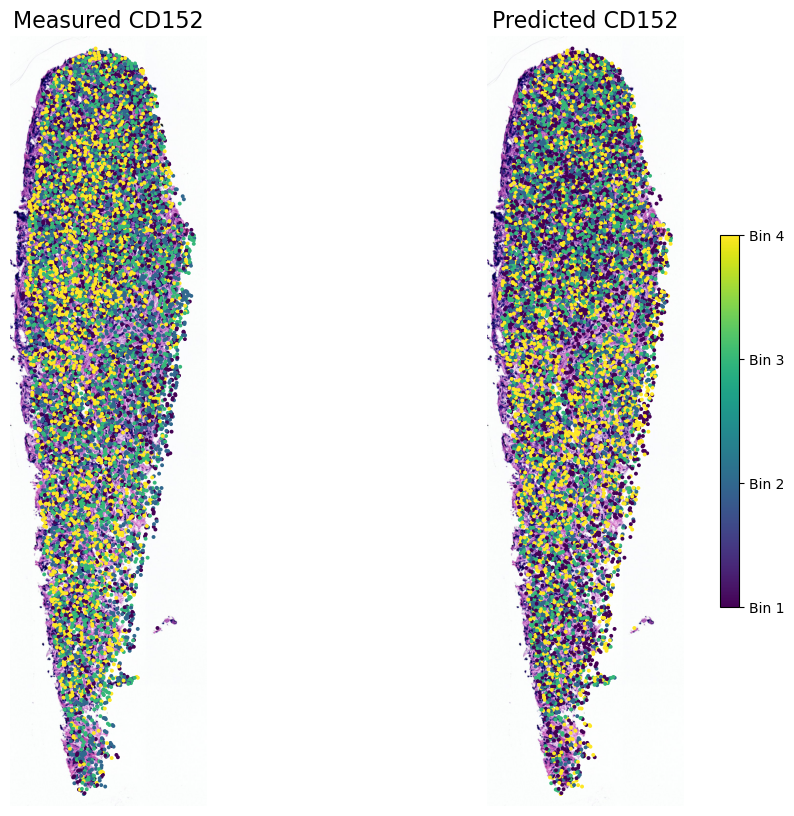

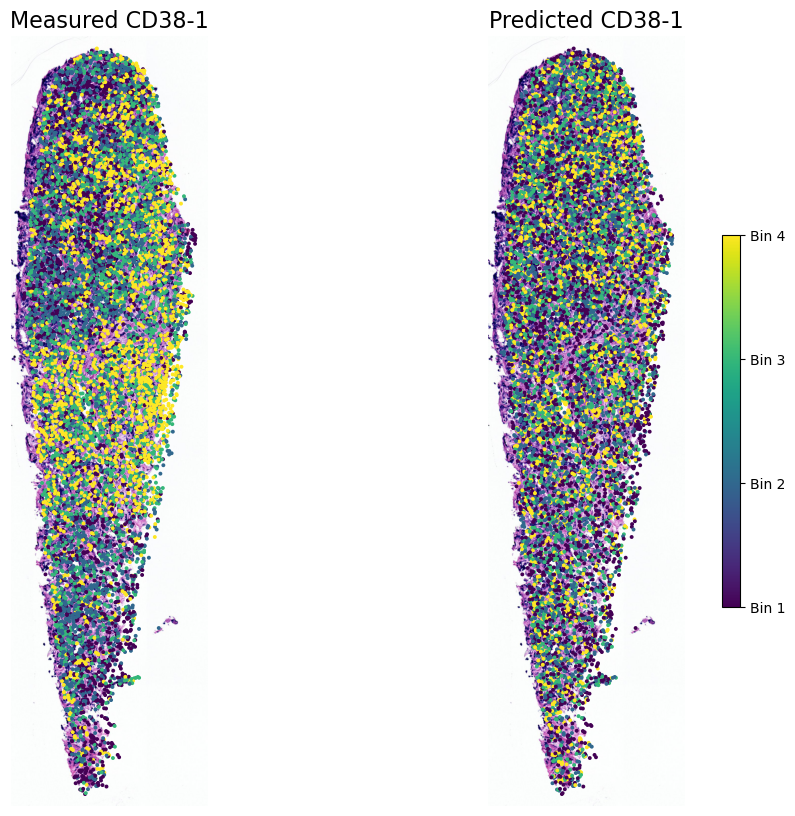

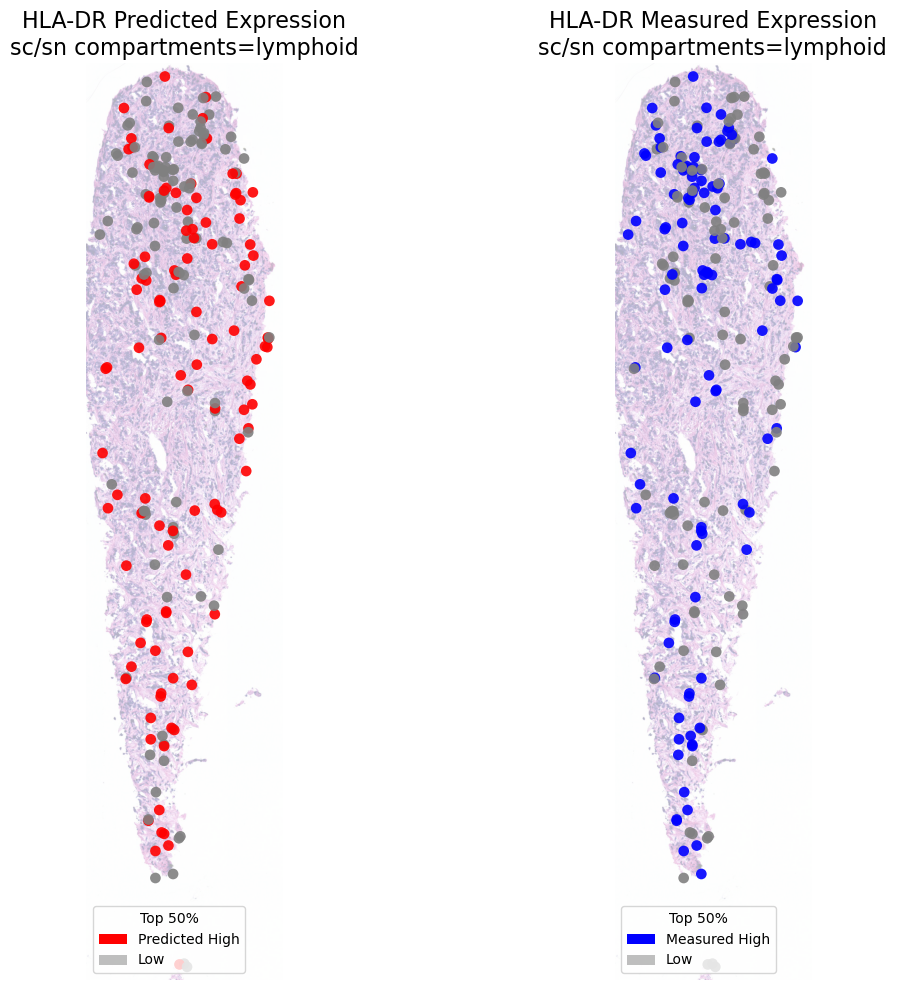

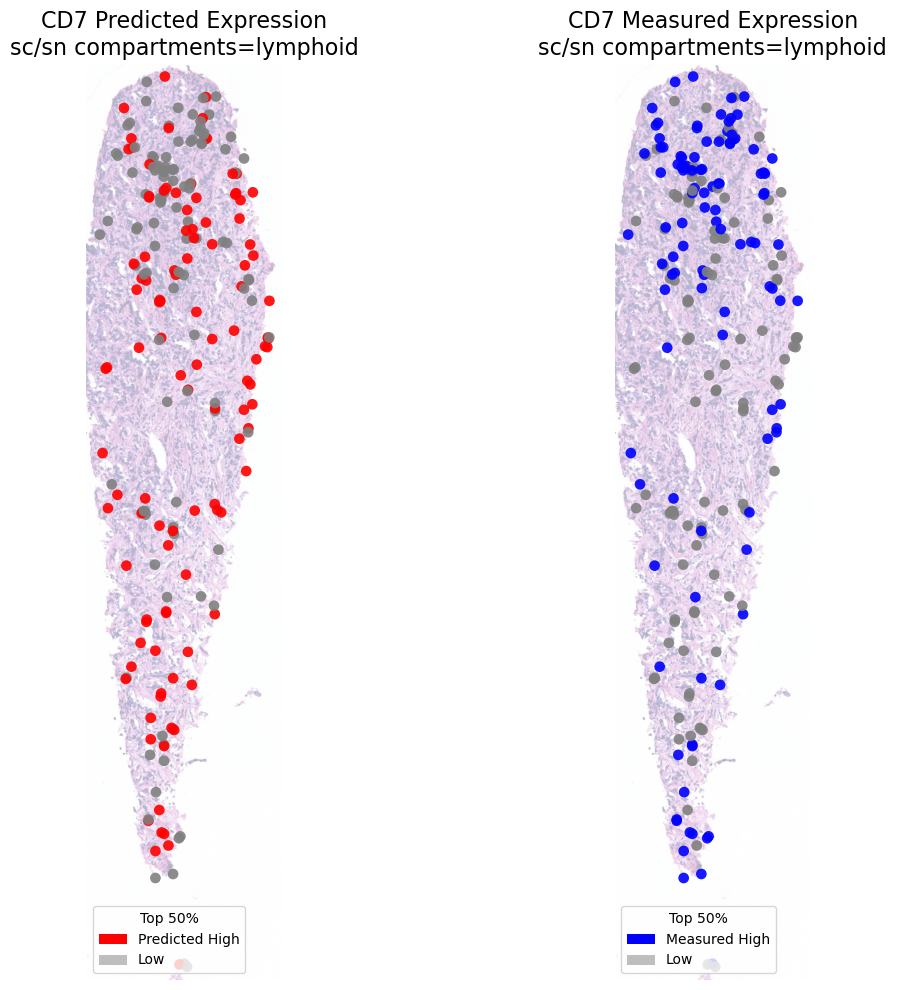

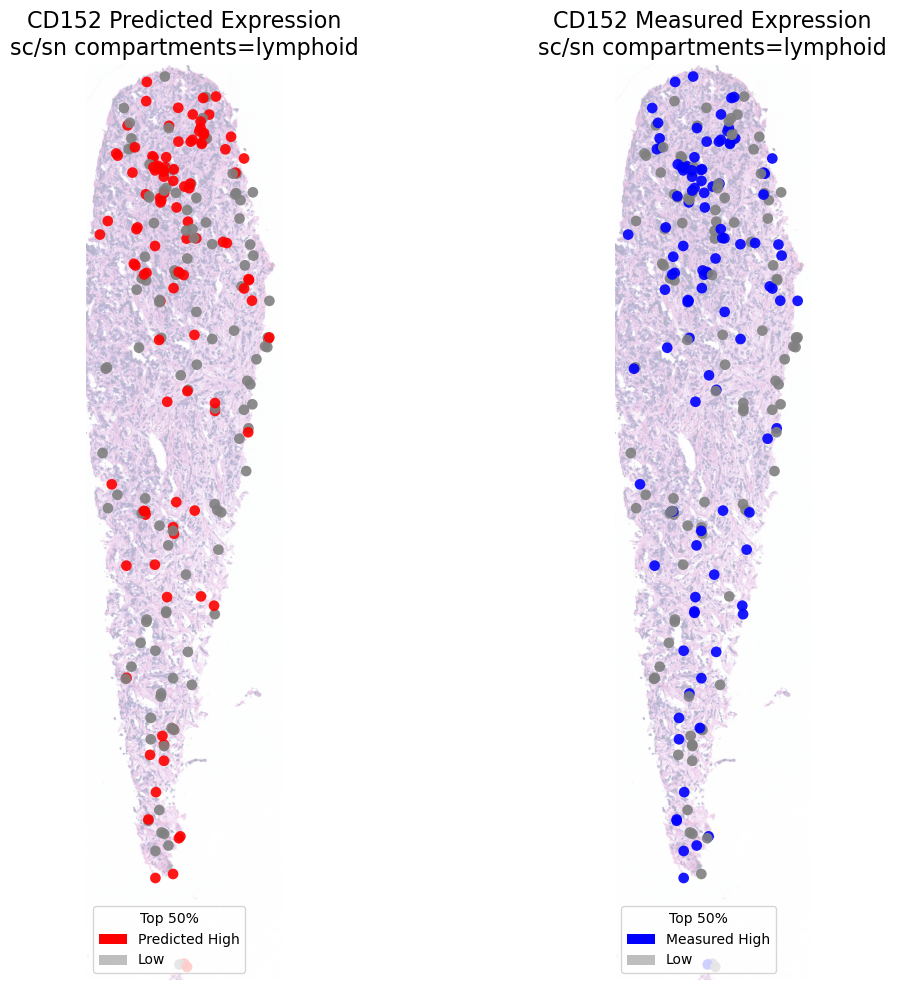

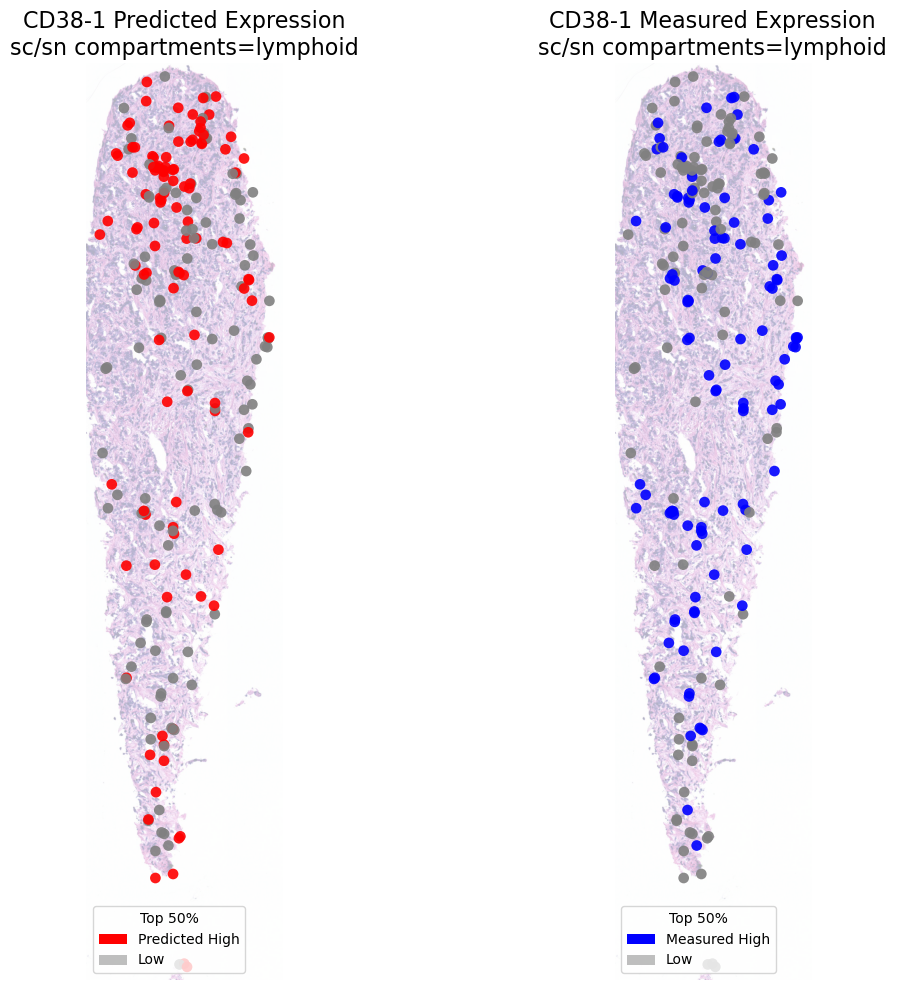

In [ ]:
import pickle
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import squidpy as sq
import os 
# Note: geomloss needs to be installed separately: pip install geomloss
# import geomloss  # Uncomment when available


def load_embeddings(rna_path, protein_path):
    """
    Load RNA and protein embeddings from pickle files.
    
    Parameters:
    -----------
    rna_path : str
        Path to the RNA embeddings pickle file
    protein_path : str
        Path to the protein embeddings pickle file
        
    Returns:
    --------
    tuple
        (rna_embeddings, protein_embeddings) as numpy arrays
    """
    with open(rna_path, 'rb') as handle:
        rna_embeddings = pickle.load(handle)
    with open(protein_path, 'rb') as handle:
        protein_embeddings = pickle.load(handle)
    
    print(f"RNA embeddings shape: {rna_embeddings.shape}")
    print(f"Protein embeddings shape: {protein_embeddings.shape}")
    
    return rna_embeddings, protein_embeddings


def compute_spot_level_predictions(rna_embeddings, protein_embeddings, scRNA_pred_path, k=50, normalize=False):
    """
    Compute spot-level protein predictions using RNA-protein alignment.
    
    Parameters:
    -----------
    rna_embeddings : numpy.ndarray
        RNA embeddings matrix
    protein_embeddings : numpy.ndarray
        Protein embeddings matrix
    scRNA_pred_path : str
        Path to scRNA anndata with predicted proteins
    k : int, default=50
        Number of top matches to consider per spot
    normalize : bool, default=False
        Whether to normalize embeddings before computing similarity
        
    Returns:
    --------
    tuple
        (predicted_protein_at_spots, scRNA_pred) - torch tensor of predictions and anndata object
    """
    # Convert to torch tensors
    rna_emb = torch.tensor(rna_embeddings)
    codex_emb = torch.tensor(protein_embeddings)
    
    # Optionally normalize embeddings
    if normalize:
        rna_emb = F.normalize(rna_emb, dim=1)
        codex_emb = F.normalize(codex_emb, dim=1)
    
    # Compute similarity matrix
    sim_matrix = torch.matmul(codex_emb, rna_emb.T)
    print(f"Similarity matrix shape: {sim_matrix.shape}")
    
    # Get top-k matches per spot
    topk_scores, topk_indices = sim_matrix.topk(k=k, dim=1)
    print(f"Top-k scores shape: {topk_scores.shape}, Top-k indices shape: {topk_indices.shape}")
    
    # Apply softmax to get weights
    weights = F.softmax(topk_scores, dim=1)
    print(f"Weights shape: {weights.shape}")
    
    # Load scRNA predictions
    scRNA_pred = sc.read_h5ad(scRNA_pred_path)
    pred_np = scRNA_pred.obsm["protein_predicted"]
    print(f"Predicted proteins shape: {pred_np.shape}")
    
    # Gather the top-k predicted protein values
    topk_protein_preds = pred_np[topk_indices.numpy()]
    
    # Apply weights to top-k predictions and sum
    weights_expanded = weights.unsqueeze(-1)
    predicted_protein_at_spots = torch.sum(weights_expanded * torch.tensor(topk_protein_preds), dim=1)
    print(f"Predicted proteins at spots shape: {predicted_protein_at_spots.shape}")
    
    return predicted_protein_at_spots, scRNA_pred


def normalize_data(x, low=1e-8, high=1):
    """
    Normalize data to a specified range.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Data to normalize
    low : float, default=1e-8
        Lower bound of the normalized range
    high : float, default=1
        Upper bound of the normalized range
        
    Returns:
    --------
    numpy.ndarray
        Normalized data
    """
    MIN = np.min(x)
    MAX = np.max(x)
    x = low + (x - MIN) / (MAX - MIN) * (high - low)
    return x


def prepare_validation_data(scRNA_pred, scP_truth, predicted_protein_at_spots, fake_p_file):
    """
    Prepare validation data by aligning predicted and measured proteins.
    
    Parameters:
    -----------
    scRNA_pred : AnnData
        scRNA data with predicted proteins
    scP_truth : AnnData
        Spatial proteomics ground truth data
    predicted_protein_at_spots : torch.Tensor
        Predicted protein expression at spots
        
    Returns:
    --------
    tuple
        (scP_truth with added columns, overlap_MYIDs list)
    """
    # Normalize data
    scP_truth.X = normalize_data(scP_truth.X)
    # convert sparse matrix to dense if needed for scRNA_pred
    if hasattr(scRNA_pred.X, 'toarray'):
        scRNA_pred.X = scRNA_pred.X.toarray()
    
    scRNA_pred.X = normalize_data(scRNA_pred.X)
    fake_p = sc.read_h5ad(fake_p_file)
    scRNA_pred.uns["protein_predicted_MYID"] = fake_p.var['MYID']
    
    # Get protein IDs
    pred_MYID_list =  [int(myid) for myid in scRNA_pred.uns['protein_predicted_MYID']]
    truth_MYID_list = list(scP_truth.var["MYID"].astype(int))
    overlap_MYIDs = list(set(pred_MYID_list).intersection(truth_MYID_list))
    
    print(f"Number of overlapping proteins: {len(overlap_MYIDs)}")
    
    # Convert predictions to DataFrame
    df_pred = pd.DataFrame(predicted_protein_at_spots.numpy(), columns=pred_MYID_list)
    
    # Add predicted protein columns to ground truth object in bulk
    pred_columns = {f"pred_protein_{myid}": df_pred[myid].values for myid in pred_MYID_list}
    scP_truth.obs = pd.concat([scP_truth.obs, pd.DataFrame(pred_columns, index=scP_truth.obs.index)], axis=1)
    
    # Add measured protein columns to ground truth object in bulk
    measured_columns = {}
    for myid in overlap_MYIDs:
        measured_col_name = f"measured_protein_{myid}"
        protein_idx = np.where(scP_truth.var["MYID"].astype(int) == myid)[0][0]
        measured_columns[measured_col_name] = scP_truth.X[:, protein_idx].flatten()
    
    scP_truth.obs = pd.concat([scP_truth.obs, pd.DataFrame(measured_columns, index=scP_truth.obs.index)], axis=1)
    
    return scP_truth, overlap_MYIDs, pred_MYID_list


import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import pearsonr, spearmanr

def plot_protein_by_region_cell_type(adata, img_path, myid, 
                                    region=None, 
                                    cell_type=None, 
                                    scale=1.0, spot_radius=6, 
                                    fig_size=(20, 10), dpi=100,
                                    padding=50,
                                    use_bins=False,
                                    n_bins=4):  # Add binning options
    """
    Plot protein expression filtered by region and/or cell type overlaid on a cropped H&E image,
    focusing only on the area with data points. Values are normalized locally.
    
    Parameters:
    -----------
    adata : AnnData
        Spatial proteomics data with measured and predicted proteins
    img_path : str
        Path to the H&E image
    myid : int
        Protein ID (MYID) to plot
    region : int or str, default=None
        Region to filter by (if None, shows all regions)
    cell_type : str, default=None
        Cell type to filter by, either 'Tumor_1' or 'ImmuneCells_1'
    scale : float, default=1.0
        Scaling factor for coordinates
    spot_radius : int, default=6
        Size of spots in the scatter plot
    fig_size : tuple, default=(20, 10)
        Figure size (width, height)
    dpi : int, default=100
        DPI for the figure
    padding : int, default=50
        Padding in pixels to add around the data region
    use_bins : bool, default=False
        Whether to discretize values into bins
    n_bins : int, default=4
        Number of bins if use_bins=True
        
    Returns:
    --------
    fig, ax, crop_coords:
        Figure, axis objects, and coordinates used for cropping
    """
    # Load the H&E image
    img = plt.imread(img_path)
    
    # Get protein name
    try:
        protein_name = adata.var.loc[adata.var["MYID"] == myid, "Protein_y"].values[0]
    except:
        try:
            protein_name = adata.var.loc[adata.var["MYID"] == myid, "Protein"].values[0]
        except:
            protein_name = f"MYID_{myid}"
    
    # Set column names
    pred_col_name = f"pred_protein_{myid}"
    measured_col_name = f"measured_protein_{myid}"
    
    # Check if columns exist
    if pred_col_name not in adata.obs.columns or measured_col_name not in adata.obs.columns:
        raise ValueError(f"Column {pred_col_name} or {measured_col_name} not found in adata.obs")
    
    # Filter observations
    mask = np.ones(len(adata.obs), dtype=bool)
    
    # Filter by region if specified
    if region is not None:
        region_mask = adata.obs['region'] == region
        mask = mask & region_mask
    
    # Filter by cell type if specified
    if cell_type is not None:
        if cell_type not in ['Tumor_1', 'ImmuneCells_1']:
            raise ValueError("cell_type must be either 'Tumor_1' or 'ImmuneCells_1'")
        
        # Only consider spots with cell type score > 0.5
        cell_type_mask = adata.obs[cell_type] > 0.5
        mask = mask & cell_type_mask
    
    # Apply filter
    filtered_obs = adata.obs[mask]
    
    # Skip if no observations pass the filters
    if len(filtered_obs) == 0:
        raise ValueError(f"No observations match the specified filters (region={region}, cell_type={cell_type})")
    
    # Calculate bounding box of data points in the filtered region
    x_coords = filtered_obs['x'].values * scale
    y_coords = filtered_obs['y'].values * scale
    
    # Calculate min and max coordinates with padding
    x_min = max(0, int(x_coords.min()) - padding)
    y_min = max(0, int(y_coords.min()) - padding)
    x_max = min(img.shape[1], int(x_coords.max()) + padding)
    y_max = min(img.shape[0], int(y_coords.max()) + padding)
    
    # Crop the image to focus on the region with data
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # Create figure
    fig, ax = plt.subplots(1, 2, figsize=fig_size, dpi=dpi)
    
    # Create title text
    region_text = f" Region {region}" if region is not None else ""
    cell_text = f" {cell_type}" if cell_type is not None else ""
    filter_text = f" ({cell_text})" if region is not None or cell_type is not None else ""
    bin_text = " (Binned)" if use_bins else ""
    if use_bins:
        # Discretize into bins using quantiles, but independently for measured and predicted
        meas = filtered_obs[measured_col_name]
        pred = filtered_obs[pred_col_name]
        
        # Use qcut for evenly distributed bins based on quantiles, independently for each
        try:
            # For measured values - local binning
            meas_bins = pd.qcut(meas, q=n_bins, labels=False)
            # For predicted values - separate local binning
            pred_bins = pd.qcut(pred, q=n_bins, labels=False)
        except ValueError as e:
            # If there are too few unique values, fall back to regular bins
            print(f"Warning: {e}. Falling back to regular binning.")
            meas_bins = pd.cut(meas, bins=n_bins, labels=False)
            pred_bins = pd.cut(pred, bins=n_bins, labels=False)
        
        # Normalize for colormap (bins are 0 to n_bins-1)
        norm = mcolors.Normalize(vmin=0, vmax=n_bins-1)
        cmap = cm.get_cmap("viridis")
        
        # Plot measured expression (binned)
        ax[0].imshow(cropped_img)
        ax[0].set_title(f"Measured {protein_name}", fontsize=16)
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].spines['top'].set_visible(False)
        ax[0].spines['right'].set_visible(False)
        ax[0].spines['bottom'].set_visible(False)
        ax[0].spines['left'].set_visible(False)
        
        # Plot each spot as a circle for measured binned values
        for idx, row in filtered_obs.iterrows():
            x = (row['x'] * scale) - x_min  # Adjust x for cropping
            y = (row['y'] * scale) - y_min  # Adjust y for cropping
            bin_val = meas_bins.loc[idx]
            
            # Check if point is within the cropped image
            if 0 <= x < cropped_img.shape[1] and 0 <= y < cropped_img.shape[0]:
                circ = Circle((x, y), radius=spot_radius, color=cmap(norm(bin_val)), linewidth=0)
                ax[0].add_patch(circ)
        
        # Plot predicted expression (binned)
        ax[1].imshow(cropped_img)
        ax[1].set_title(f"Predicted {protein_name}", fontsize=16)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].spines['bottom'].set_visible(False)
        ax[1].spines['left'].set_visible(False)
        
        # Plot each spot as a circle for predicted binned values
        for idx, row in filtered_obs.iterrows():
            x = (row['x'] * scale) - x_min  # Adjust x for cropping
            y = (row['y'] * scale) - y_min  # Adjust y for cropping
            bin_val = pred_bins.loc[idx]
            
            # Check if point is within the cropped image
            if 0 <= x < cropped_img.shape[1] and 0 <= y < cropped_img.shape[0]:
                circ = Circle((x, y), radius=spot_radius, color=cmap(norm(bin_val)), linewidth=0)
                ax[1].add_patch(circ)
        
        # Add single shared colorbar for both plots
        sm = cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
        cbar.set_ticks(np.linspace(0, n_bins-1, n_bins))
        cbar.set_ticklabels([f"Bin {i+1}" for i in range(n_bins)])
    
 
    return fig, ax, (x_min, y_min, x_max, y_max)  # Return crop coordinates for reference




def plot_categorical_cell_types(adata, img_path, cell_type_col,
                               region=None, 
                               scale=1.0, spot_radius=6, 
                               fig_size=(12, 10), dpi=100,
                               padding=50, legend_loc='best'):
    """
    Plot spots colored by categorical cell type values overlaid on an H&E image.
    
    Parameters:
    -----------
    adata : AnnData
        Spatial proteomics data
    img_path : str
        Path to the H&E image
    cell_type_col : str
        Column name in adata.obs containing categorical cell type values
    region : int or str, default=None
        Region to filter by (if None, shows all regions)
    scale : float, default=1.0
        Scaling factor for coordinates
    spot_radius : int, default=6
        Size of spots in the scatter plot
    fig_size : tuple, default=(12, 10)
        Figure size (width, height)
    dpi : int, default=100
        DPI for the figure
    padding : int, default=50
        Padding in pixels to add around the data region
    legend_loc : str, default='best'
        Location for the legend
        
    Returns:
    --------
    fig, ax, crop_coords:
        Figure, axis objects, and coordinates used for cropping
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    import numpy as np
    
    # Load the H&E image
    img = plt.imread(img_path)
    
    # Check if cell type column exists
    if cell_type_col not in adata.obs.columns:
        raise ValueError(f"Column {cell_type_col} not found in adata.obs")
    
    # Filter observations
    mask = np.ones(len(adata.obs), dtype=bool)
    
    # Filter by region if specified
    if region is not None:
        region_mask = adata.obs['region'] == region
        mask = mask & region_mask
    
    # Apply filter
    filtered_obs = adata.obs[mask]
    
    # Skip if no observations pass the filters
    if len(filtered_obs) == 0:
        raise ValueError(f"No observations match the region filter (region={region})")
    
    # Extract unique cell types and assign colors
    cell_types = filtered_obs[cell_type_col].unique()
    
    # Calculate bounding box of data points in the filtered region
    x_coords = filtered_obs['x'].values * scale
    y_coords = filtered_obs['y'].values * scale
    
    # Calculate min and max coordinates with padding
    x_min = max(0, int(x_coords.min()) - padding)
    y_min = max(0, int(y_coords.min()) - padding)
    x_max = min(img.shape[1], int(x_coords.max()) + padding)
    y_max = min(img.shape[0], int(y_coords.max()) + padding)
    
    # Crop the image to focus on the region with data
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # Create figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)
    
    # Create title text
    region_text = f" Region {region}" if region is not None else ""
    
    # Plot base image
    ax.imshow(cropped_img, alpha=0.1)
    ax.set_title(f"{cell_type_col}", fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create a color dictionary for the cell types
    # Generate colors automatically using tab10, tab20, or similar colormap
    import matplotlib.cm as cm
    import matplotlib.colors as mcolors
    
    # Choose colormap based on number of cell types
    if len(cell_types) <= 10:
        colormap = cm.get_cmap('tab10', len(cell_types))
    elif len(cell_types) <= 20:
        colormap = cm.get_cmap('tab20', len(cell_types))
    else:
        # For more than 20 types, create a custom colormap
        colormap = plt.cm.get_cmap('hsv', len(cell_types))
    
    color_dict = {cell_type: colormap(i) for i, cell_type in enumerate(cell_types)}
    
    # Plot each cell type with different colors
    for cell_type in cell_types:
        # Filter observations for this cell type
        cells = filtered_obs[filtered_obs[cell_type_col] == cell_type]
        
        # Create a sample circle for the legend
        ax.plot([], [], 'o', color=color_dict[cell_type], label=cell_type, markersize=10)
        
        # Plot all spots for this cell type
        for idx, row in cells.iterrows():
            x = (row['x'] * scale) - x_min  # Adjust x for cropping
            y = (row['y'] * scale) - y_min  # Adjust y for cropping
            
            # Check if point is within the cropped image
            if 0 <= x < cropped_img.shape[1] and 0 <= y < cropped_img.shape[0]:
                circ = Circle((x, y), radius=spot_radius, color=color_dict[cell_type], linewidth=0)
                ax.add_patch(circ)
    
    # Add legend
    ax.legend(loc='best', frameon=True)
    
    # save the figure
    # plt.savefig(f"cell_type_plot_{cell_type_col}{region_text}.png", dpi=dpi, bbox_inches='tight')
    plt.tight_layout()
    
    return fig, ax, (x_min, y_min, x_max, y_max)


def plot_protein_delta_by_cell_type_split(adata, img_path, myid, 
                                cell_type_col, cell_type_value,
                                region=None, 
                                percentile_threshold=90,
                                scale=1.0, spot_radius=6, 
                                fig_size=(12, 10), dpi=100,
                                padding=50):
    """
    Create two delta maps showing agreement/disagreement between measured and predicted protein expression
    filtered by cell type category and region. Plots separately:
    1. Predicted high vs low
    2. Measured high vs low
    
    Parameters:
    -----------
    adata : AnnData
        Spatial proteomics data
    img_path : str
        Path to the H&E image
    myid : int
        Protein ID (MYID) to plot
    cell_type_col : str
        Column name in adata.obs containing categorical cell type values
    cell_type_value : str
        Specific cell type value to filter by (e.g., 'lymphoid')
    region : int or str, default=None
        Region to filter by (if None, shows all regions)
    percentile_threshold : int, default=90
        Percentile threshold for "highly expressed" (default 90%)
    scale : float, default=1.0
        Scaling factor for coordinates
    spot_radius : int, default=6
        Size of spots in the scatter plot
    fig_size : tuple, default=(12, 10)
        Figure size (width, height) for each subplot
    dpi : int, default=100
        DPI for the figure
    padding : int, default=50
        Padding in pixels to add around the data region
        
    Returns:
    --------
    fig, axes, crop_coords:
        Figure, axes objects, and coordinates used for cropping
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle, Patch
    import numpy as np
    
    # Load the H&E image
    img = plt.imread(img_path)
    
    # Get protein name
    try:
        protein_name = adata.var.loc[adata.var["MYID"] == myid, "Protein_y"].values[0]
    except:
        try:
            protein_name = adata.var.loc[adata.var["MYID"] == myid, "Protein"].values[0]
        except:
            protein_name = f"MYID_{myid}"
    
    # Set column names
    pred_col_name = f"pred_protein_{myid}"
    measured_col_name = f"measured_protein_{myid}"
    
    # Check if columns exist
    if pred_col_name not in adata.obs.columns or measured_col_name not in adata.obs.columns:
        raise ValueError(f"Column {pred_col_name} or {measured_col_name} not found in adata.obs")
    
    if cell_type_col not in adata.obs.columns:
        raise ValueError(f"Cell type column {cell_type_col} not found in adata.obs")
    
    # Filter observations
    mask = np.ones(len(adata.obs), dtype=bool)
    
    # Filter by region if specified
    if region is not None:
        region_mask = adata.obs['region'] == region
        mask = mask & region_mask
    
    # Filter by cell type
    cell_type_mask = adata.obs[cell_type_col] == cell_type_value
    mask = mask & cell_type_mask
    
    # Apply filter
    filtered_obs = adata.obs[mask]
    
    # Skip if no observations pass the filters
    if len(filtered_obs) == 0:
        raise ValueError(f"No observations match the filters (region={region}, {cell_type_col}={cell_type_value})")
    
    # Calculate thresholds for "highly expressed" (top X percentile)
    measured_threshold = np.percentile(filtered_obs[measured_col_name], percentile_threshold)
    predicted_threshold = np.percentile(filtered_obs[pred_col_name], percentile_threshold)
    
    # Calculate bounding box of data points in the filtered region
    x_coords = filtered_obs['x'].values * scale
    y_coords = filtered_obs['y'].values * scale
    
    # Calculate min and max coordinates with padding
    x_min = max(0, int(x_coords.min()) - padding)
    y_min = max(0, int(y_coords.min()) - padding)
    x_max = min(img.shape[1], int(x_coords.max()) + padding)
    y_max = min(img.shape[0], int(y_coords.max()) + padding)
    
    # Crop the image to focus on the region with data
    cropped_img = img[y_min:y_max, x_min:x_max]
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(fig_size[0]*2, fig_size[1]), dpi=dpi)
    
    # Create title text
    region_text = f" Region {region}" if region is not None else ""
    
    # Define plot titles
    titles = [
        f"{protein_name} Predicted Expression\n{cell_type_col}={cell_type_value}",
        f"{protein_name} Measured Expression\n{cell_type_col}={cell_type_value}"
    ]
    
    # Define colors for each plot
    colors = {
        'low': 'gray',
        'pred_high': 'red',
        'measured_high': 'blue'
    }
    
    # Create both plots
    for i, ax in enumerate(axes):
        # Plot base image
        ax.imshow(cropped_img, alpha=0.3)
        ax.set_title(titles[i], fontsize=16)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        # Color spots based on expression patterns for each plot
        for idx, row in filtered_obs.iterrows():
            x = (row['x'] * scale) - x_min  # Adjust x for cropping
            y = (row['y'] * scale) - y_min  # Adjust y for cropping
            
            # Check if point is within the cropped image
            if 0 <= x < cropped_img.shape[1] and 0 <= y < cropped_img.shape[0]:
                measured_val = row[measured_col_name]
                pred_val = row[pred_col_name]
                
                # Determine color based on which plot we're on
                if i == 0:  # Predicted plot
                    if pred_val >= predicted_threshold:
                        color = colors['pred_high']
                        alpha = 0.9
                    else:
                        color = colors['low']
                        alpha = 0.9
                else:  # Measured plot
                    if measured_val >= measured_threshold:
                        color = colors['measured_high']
                        alpha = 0.9
                    else:
                        color = colors['low']
                        alpha = 0.9
                
                # Create circle with appropriate color
                circ = Circle((x, y), radius=spot_radius, color=color, alpha=alpha, linewidth=0)
                ax.add_patch(circ)
        
        # Create legends
        if i == 0:  # Predicted plot
            legend_elements = [
                Patch(facecolor=colors['pred_high'], edgecolor='none', label='Predicted High'),
                Patch(facecolor=colors['low'], edgecolor='none', alpha=0.5, label='Low')
            ]
        else:  # Measured plot
            legend_elements = [
                Patch(facecolor=colors['measured_high'], edgecolor='none', label='Measured High'),
                Patch(facecolor=colors['low'], edgecolor='none', alpha=0.5, label='Low')
            ]
        
        # Add legend
        ax.legend(handles=legend_elements, loc='best', title=f"Top {percentile_threshold}%")
        
        # Add threshold information
        if i == 0:
            threshold_value = predicted_threshold
            threshold_type = "Predicted"
        else:
            threshold_value = measured_threshold
            threshold_type = "Measured"
            
        #info_text = f"{threshold_type} threshold (top {percentile_threshold}%)"
        
        # Position the text in the upper left
        # ax.text(0.02, 0.98, info_text, transform=ax.transAxes, fontsize=9,
        #         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    
    plt.tight_layout()
    
    return fig, axes, (x_min, y_min, x_max, y_max)




def calculate_mmd_scores(truth_np, pred_prot_np, blur_values=None):
    """
    Calculate Maximum Mean Discrepancy (MMD) between truth and predicted distributions.
    
    Parameters:
    -----------
    truth_np : numpy.ndarray
        Ground truth protein expression values
    pred_prot_np : numpy.ndarray
        Predicted protein expression values
    blur_values : list, default=None
        List of blur values to test. If None, uses [0.01, 0.05, 0.1, 0.5]
        
    Returns:
    --------
    dict
        Dictionary of blur values to MMD scores
    """
    try:
        from geomloss import SamplesLoss
    except ImportError:
        print("geomloss not installed. Install with: pip install geomloss")
        return None
        
    if blur_values is None:
        blur_values = [0.01, 0.05, 0.1, 0.5]
    
    truth_tensor = torch.tensor(truth_np).float()
    pred_tensor = torch.tensor(pred_prot_np).float()
    
    mmd_scores = {}
    for blur in blur_values:
        loss = SamplesLoss("gaussian", blur=blur)  # or "energy", "sinkhorn"
        mmd_value = loss(truth_tensor, pred_tensor)
        mmd_scores[blur] = mmd_value.item()
    
    return mmd_scores

rna_path = '/raid/home/yoyowu/spatialpro/prediction/spatial_liver_rna_embeddings.pickle'
protein_path = '/raid/home/yoyowu/spatialpro/prediction/spatial_protein_embeddings.pickle'
scRNA_pred_path = '/raid/home/yoyowu/spatialpro/prediction/HTAPP_liver_scRNA_with_predicted_proteins_2484.h5ad'
scP_truth_path = '/raid/home/yoyowu/spatialpro/data/HTAPP/liver_mar12_protein_w_ID.h5ad'
fake_p_file_path = '/raid/home/yoyowu/spatialpro/prediction/scP_artificial_HTAPP_n_liver.h5ad'
k=50
print("1. Loading embeddings...")
rna_embeddings, protein_embeddings = load_embeddings(rna_path, protein_path)

print("\n2. Computing spot-level predictions...")
predicted_protein_at_spots, scRNA_pred = compute_spot_level_predictions(
    rna_embeddings, protein_embeddings, scRNA_pred_path, k=k
)

print("\n3. Loading ground truth data...")
scP_truth = sc.read_h5ad(scP_truth_path)

print("\n4. Preparing validation data...")
scP_truth, overlap_MYIDs,pred_MYID_list = prepare_validation_data(
    scRNA_pred, scP_truth, predicted_protein_at_spots, fake_p_file_path
    )



# start plotting
img_path = '/raid/home/yoyowu/spatialpro/data/HTAPP/HTAPP-313-SMP-932_HE_1_processed.jpg'
plot_myid_list = [4580,12036,2226, 3313]


fig, ax, _ = plot_categorical_cell_types(
    scP_truth, 
    img_path, 
    cell_type_col='sc/sn compartments',  # Your column with categorical values like 'B', 'T', 'Plasma'
    region=3,
    spot_radius=10, fig_size=(15, 10)
)

fig, ax, _ = plot_categorical_cell_types(
    scP_truth, 
    img_path, 
    cell_type_col='OT',  # Your column with categorical values like 'B', 'T', 'Plasma'
    region=3,
    spot_radius=10, fig_size=(15, 10)
)



region = 3
cell_type = 'Tumor_1'
# plot whole regions 
for myid in [3313, 12036]:
    fig, ax, _ = plot_protein_by_region_cell_type(
        scP_truth, img_path, myid=myid, spot_radius=8, fig_size=(12, 10),
        region=None, cell_type=cell_type,
        use_bins=True, n_bins=4
    )

# plot reigion 3 
for myid in plot_myid_list:
    fig, ax, _ = plot_protein_by_region_cell_type(
        scP_truth, img_path, myid=myid, spot_radius=8, fig_size=(12, 10),
        region=region, cell_type=cell_type,
        use_bins=True, n_bins=4
    )
 
# for immune markers 
immunue_myid_list = [4580,12036,2226, 3313]
for myid in immunue_myid_list:
    fig, ax, _ = plot_protein_delta_by_cell_type_split(
        scP_truth, img_path, myid=myid,
        region=region, cell_type_col='sc/sn compartments', cell_type_value='lymphoid',
        percentile_threshold=50,
        spot_radius=20,
        fig_size=(7,10)
    )




C. Calculating Maximum Mean Discrepancy (MMD) at the cell level...


Cell-level MMD comparisons:
CODEX measured vs Predicted proteins:
  Blur: 0.01, MMD predicted to truth: 0.000057
  Blur: 0.02, MMD predicted to truth: 0.000057
  Blur: 0.04, MMD predicted to truth: 0.000488
  Blur: 0.06, MMD predicted to truth: 0.005734
CODEX measured vs RNA expression:
  Blur: 0.01, MMD RNA to truth: 0.000823
  Blur: 0.02, MMD RNA to truth: 0.001639
  Blur: 0.04, MMD RNA to truth: 0.002777
  Blur: 0.06, MMD RNA to truth: 0.003930


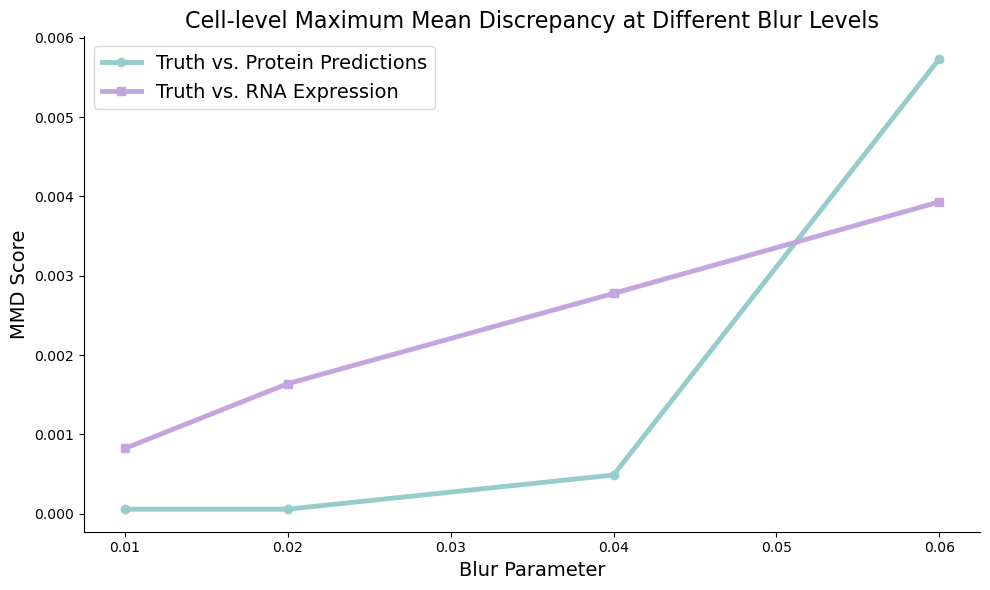

In [10]:
print("\nC. Calculating Maximum Mean Discrepancy (MMD) at the cell level...")
# Extract overlapping indices for consistent comparison
pred_MYID_list = list(scRNA_pred.uns['protein_predicted_MYID'])
truth_MYID_list = list(scP_truth.var["MYID"].astype(int))

# Get indices for overlapping proteins
pred_indices = [pred_MYID_list.index(mid) for mid in overlap_MYIDs]
truth_indices = [np.where(np.array(truth_MYID_list) == mid)[0][0] for mid in overlap_MYIDs]

# Get the data
truth_np = scP_truth.X[:, truth_indices]
pred_np = scRNA_pred.obsm["protein_predicted"][:, pred_indices]

# Get RNA expression data for the same genes if available
rna_np = None
if hasattr(scRNA_pred, 'X') and scRNA_pred.X is not None:
    if pred_indices[0] < scRNA_pred.X.shape[1]:
        rna_np = scRNA_pred.X[:, pred_indices]

# Calculate MMD with different blur values
blur_values = [0.01, 0.02, 0.04, 0.06]
cell_pred_mmd = calculate_mmd_scores(truth_np, pred_np, blur_values)
cell_rna_mmd = calculate_mmd_scores(truth_np, rna_np, blur_values) if rna_np is not None else None

# Print and visualize MMD scores
print("Cell-level MMD comparisons:")
mmd_results = {}

if cell_pred_mmd:
    print("CODEX measured vs Predicted proteins:")
    for blur, score in cell_pred_mmd.items():
        print(f"  Blur: {blur}, MMD predicted to truth: {score:.6f}")
        mmd_results[f"pred_blur_{blur}"] = score
        
if cell_rna_mmd:
    print("CODEX measured vs RNA expression:")
    for blur, score in cell_rna_mmd.items():
        print(f"  Blur: {blur}, MMD RNA to truth: {score:.6f}")
        mmd_results[f"rna_blur_{blur}"] = score



# Visualize MMD scores
plt.figure(figsize=(10, 6))

if cell_pred_mmd:
    plt.plot(blur_values, [cell_pred_mmd[b] for b in blur_values], 'o-', 
            label='Truth vs. Protein Predictions', linewidth=3.5, color='#96cccb')

if cell_rna_mmd:
    plt.plot(blur_values, [cell_rna_mmd[b] for b in blur_values], 's-', 
            label='Truth vs. RNA Expression', linewidth=3.5, color='#c4a5de')

#c4a5de



#96cccb
# plt.xscale('log')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines.set_color('grey')
plt.xlabel('Blur Parameter', fontsize=14)
plt.ylabel('MMD Score',fontsize = 14)
plt.title('Cell-level Maximum Mean Discrepancy at Different Blur Levels', fontsize=16)
plt.legend(fontsize=14)
# plt.grid(True, alpha=0.3)
plt.tight_layout()


In [13]:
if "spatial_connectivities" not in scP_truth.obsp:
        scP_truth.obsp["spatial_connectivities"] = scP_truth.obsp["connectivities"]

   # Get column names for all predicted proteins
pred_protein_cols = [col for col in scP_truth.obs.columns if col.startswith("pred_protein_") and not col.endswith("smoothed")]

# Calculate Moran's I for all predicted proteins
sq.gr.spatial_autocorr(
    scP_truth,
    mode="moran",
    genes=pred_protein_cols,
    layer=None,
    attr="obs",
)

all_moran_pred = pd.DataFrame({
    "Moran_I": scP_truth.uns["moranI"]["I"],
    "p_value": scP_truth.uns["moranI"]["pval_norm"]
}, index=pred_protein_cols)

# Add protein ID as separate column for easier filtering
all_moran_pred['Protein_ID'] = all_moran_pred.index.str.split('_').str[-1].astype(int)

In [14]:
all_moran_pred

Moran_I  p_value  Protein_ID
pred_protein_4      0.596425      0.0           4
pred_protein_8      0.362857      0.0           8
pred_protein_11     0.310797      0.0          11
pred_protein_12     0.570596      0.0          12
pred_protein_13     0.576037      0.0          13
...                      ...      ...         ...
pred_protein_22602  0.474864      0.0       22602
pred_protein_22603  0.558339      0.0       22603
pred_protein_22604  0.551806      0.0       22604
pred_protein_22605  0.559472      0.0       22605
pred_protein_22606  0.583569      0.0       22606

[2484 rows x 3 columns]

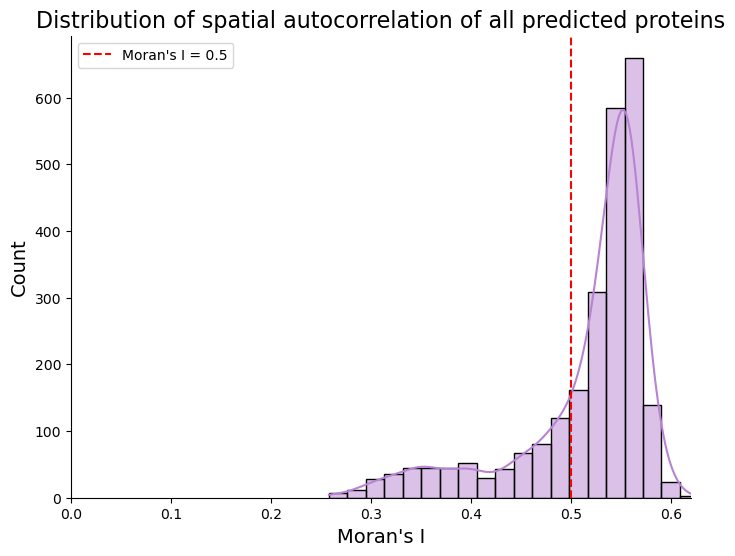

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.histplot(data=all_moran_pred, x="Moran_I", bins=20, kde=True, color="#b883d3")
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(0.5, color='red', linestyle='--', label="Moran's I = 0.5")
plt.title("Distribution of spatial autocorrelation of all predicted proteins", fontsize=16)
plt.xlabel("Moran's I", fontsize=14)
plt.ylabel("Count",fontsize=14)
# not grid
# x start with 0
plt.xlim(0.0, 0.62)
plt.grid(False)
plt.legend()

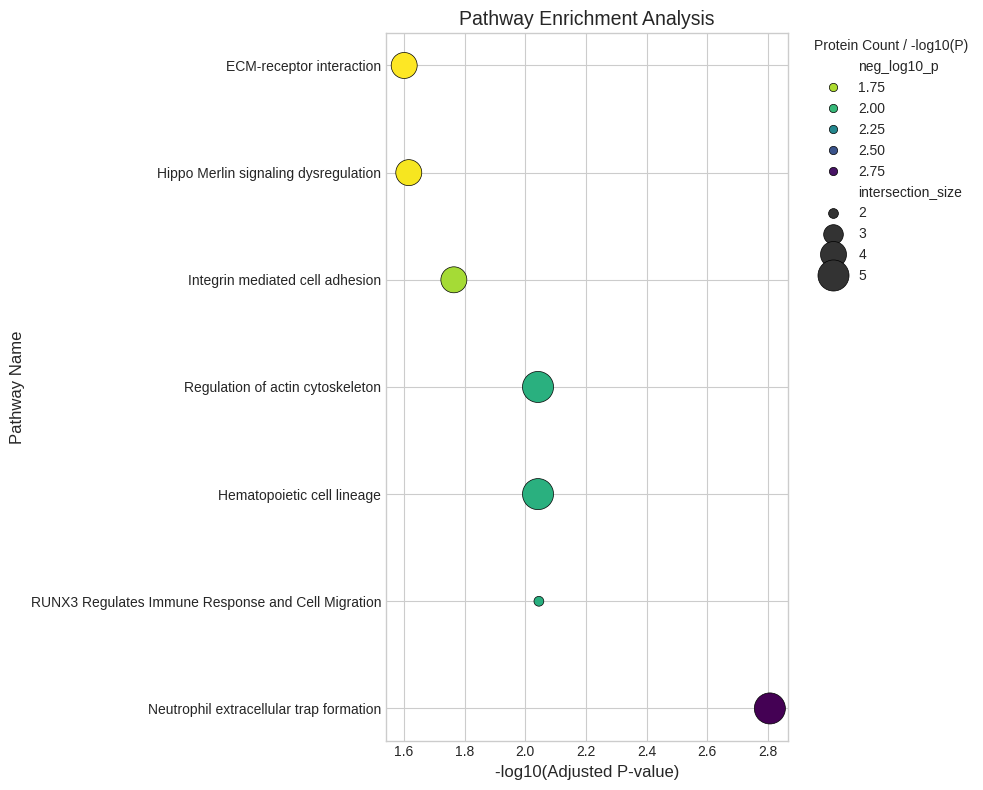

Found 7 matching pathways:
1. ECM-receptor interaction (p=2.51e-02, genes=4)
2. Hippo Merlin signaling dysregulation (p=2.42e-02, genes=4)
3. Integrin mediated cell adhesion (p=1.72e-02, genes=4)
4. Regulation of actin cytoskeleton (p=9.08e-03, genes=5)
5. Hematopoietic cell lineage (p=9.08e-03, genes=5)
6. RUNX3 Regulates Immune Response and Cell Migration (p=9.02e-03, genes=2)
7. Neutrophil extracellular trap formation (p=1.56e-03, genes=5)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
input_csv_file = '/raid/home/yoyowu/spatialpro/spatial_res/HTAPP_liver/liver_gProfiler_hsapiens_5-14-2025_10-03-21 PM__intersections.csv'


specified_pathway_names = [
    'ECM-receptor interaction',
    'Hippo Merlin signaling dysregulation',
    'Integrin mediated cell adhesion',
    'Regulation of actin cytoskeleton',
    'RUNX3 regulates immune response and cell migration',
    'Hematopoietic cell lineage',
    'Neutrophil extracellular trap formation'
    # Add or modify pathways as needed
]

# --- End Configuration ---

# Load the enrichment data
try:
    df = pd.read_csv(input_csv_file)
    
    # Filter for the specified pathways (case insensitive partial matching)
    df_filtered = pd.DataFrame()
    for pathway in specified_pathway_names:
        # Find pathways that contain the specified name (case insensitive)
        matches = df[df['term_name'].str.contains(pathway, case=False, na=False)]
        df_filtered = pd.concat([df_filtered, matches])
    
    # If no matches were found, inform the user
    if df_filtered.empty:
        print("No matching pathways found. Check the pathway names or the input file.")
    else:
        # --- Data Cleaning and Calculation ---
        # Ensure 'adjusted_p_value' is numeric and handle potential issues
        df_filtered['adjusted_p_value'] = pd.to_numeric(df_filtered['adjusted_p_value'], errors='coerce')
        
        df_filtered.dropna(subset=['adjusted_p_value'], inplace=True)
        df_filtered = df_filtered[df_filtered['adjusted_p_value'] > 0]  # Keep only positive p-values for log transform

        # Calculate -log10(adjusted p-value)
        df_filtered['neg_log10_p'] = -np.log10(df_filtered['adjusted_p_value'])

        # Ensure 'intersection_size' is numeric
        df_filtered['intersection_size'] = pd.to_numeric(df_filtered['intersection_size'], errors='coerce')
        df_filtered.dropna(subset=['intersection_size'], inplace=True)

        # Sort by significance for better visualization
        df_filtered.sort_values('neg_log10_p', ascending=True, inplace=True)

        # --- Create the Dot Plot ---
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 8))  # Adjusted size for potentially longer labels

        plot = sns.scatterplot(
            data=df_filtered,
            y='term_name',
            x='neg_log10_p',
            size='intersection_size',
            sizes=(50, 500),
            hue='neg_log10_p',
            palette='viridis_r',  # Use reversed palette so darker is more significant
            legend='brief',
            edgecolor='black',
            linewidth=0.5
        )

        # Customize plot
        plt.title('Pathway Enrichment Analysis', fontsize=14)
        plt.xlabel('-log10(Adjusted P-value)', fontsize=12)
        plt.ylabel('Pathway Name', fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        plt.legend(title='Protein Count / -log10(P)', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout
        plt.savefig('/raid/home/yoyowu/spatialpro/spatial_res/HTAPP_liver/may15pathway.png', dpi=300, bbox_inches='tight')
        # Display the plot
        plt.show()

        # Print the matching pathways for reference
        print(f"Found {len(df_filtered)} matching pathways:")
        for i, (idx, row) in enumerate(df_filtered.iterrows()):
            print(f"{i+1}. {row['term_name']} (p={row['adjusted_p_value']:.2e}, genes={int(row['intersection_size'])})")

except FileNotFoundError:
    print(f"Error: '{input_csv_file}' not found. Please ensure the file is in the correct directory.")
except KeyError as e:
    print(f"Error: Column '{e}' not found in '{input_csv_file}'. Please check the CSV file's header.")
except Exception as e:
    print(f"An error occurred: {e}")